# VQ-VAE test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
import genus as gn
import numpy
from genus.util_data import  DataloaderWithLoad, ConditionalRandomCrop, DatasetInMemory
from genus.util import linear_interpolation, append_to_dict, ckpt2file, load_yaml_as_dict, load_obj
from genus.util_vis import show_batch
from genus.model import CompositionalVae, instantiate_optimizer, instantiate_scheduler, process_one_epoch
from functools import partial
import torchvision
from torchvision import transforms

In [4]:
config_file = "./config_VQVAE.yaml"
config = load_yaml_as_dict(config_file)
BATCH_SIZE = config["simulation"]["BATCH_SIZE"]

In [5]:
# We transform them to tensors
transform = transforms.ToTensor()

train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Load and transform data
train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)


train_dataset = DatasetInMemory(x=train_data.data.unsqueeze(-3).float()/(255.0),
                                y=train_data.targets,
                                store_in_cuda=False)
test_dataset = DatasetInMemory(x=test_data.data.unsqueeze(-3).float()/(255.0),
                               y=test_data.targets,
                               store_in_cuda=False)

BATCH_SIZE = 8
test_loader = DataloaderWithLoad(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataloaderWithLoad(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Create the dataloader as usual

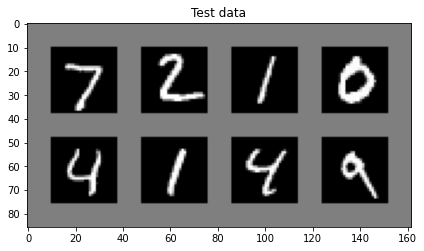

In [6]:
img, _, _ = test_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Test data",  pad_value=0.5, n_padding=10)

In [7]:
config_file = "./config_VQVAE.yaml"
config = load_yaml_as_dict(config_file)

In [8]:
from typing import NamedTuple, Optional
from torch.nn import functional as F

from genus.namedtuple import Output, MetricMiniBatch
from genus.util_ml import Quantizer
    
class ZZ(NamedTuple):
    z: torch.Tensor
    zq: torch.Tensor
    index: torch.Tensor
    
class NewEncoderConv(torch.nn.Module):
    def __init__(self, size: int, ch_in: int, dim_z: int):
        super().__init__()
        self.ch_in = ch_in
        self.width = size
        self.dim_z = dim_z
        assert size==28

       # self.conv = torch.nn.Sequential(
       #     torch.nn.Conv2d(in_channels=self.ch_in, out_channels=16, kernel_size=4, stride=2, padding=1),  # 16,16
       #     torch.nn.ReLU(inplace=True),
       #     torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),  # 8,8
       #     torch.nn.ReLU(inplace=True),
       #     torch.nn.Conv2d(in_channels=32, out_channels=self.dim_z, kernel_size=4, stride=2, padding=1),  # 4,4
       # )
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=self.ch_in, out_channels=16, kernel_size=3, stride=2, padding=1),  # 14,14
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),  # 7,7
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=32, out_channels=self.dim_z, kernel_size=3, stride=1, padding=1),  # 7,7
        )

    def forward(self, x: torch.Tensor):
        return self.conv(x)
    
class NewDecoderConv(torch.nn.Module):
    def __init__(self, size: int, ch_out: int, dim_z: int):
        super().__init__()
        self.ch_out = ch_out
        self.width = size
        self.dim_z = dim_z
        assert size==28
        
        #self.upconv = torch.nn.Sequential(
        #    torch.nn.ConvTranspose2d(in_channels=self.dim_z, out_channels=32, kernel_size=4, stride=2, padding=1),  # 8,8
        #    torch.nn.ReLU(inplace=True),
        #    torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),  # 16,16
        #    torch.nn.ReLU(inplace=True),
        #    torch.nn.ConvTranspose2d(in_channels=16, out_channels=self.ch_out, kernel_size=4, stride=2, padding=1),  # 32,32
        #)
        
        self.upconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=self.dim_z, out_channels=32, kernel_size=4, stride=2, padding=1),  # 14,14
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),  # 28,28
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=self.ch_out, kernel_size=3, stride=1, padding=1),  # 28,28
        )
        
    def forward(self, z: torch.Tensor):
        return self.upconv(z)
    

class VQVAE(torch.nn.Module):
    def __init__(self, ch_img: int, word_size: int, dictionary_size: int) -> None:
        super().__init__()
        self.vq_beta = 0.25
        self.dim_z = word_size
        self.dictionary_size = dictionary_size
        self.ch_img = ch_img
        self.encoder = NewEncoderConv(size=28, ch_in=self.ch_img, dim_z=self.dim_z)
        self.decoder = NewDecoderConv(size=28, ch_out=self.ch_img, dim_z=self.dim_z)
        self.quantizer = Quantizer(num_embeddings=self.dictionary_size, embedding_dim=self.dim_z)
        
        if torch.cuda.is_available():
            self.cuda()
    
    
    def forward(self, imgs_in, 
                iom_threshold=None, 
                noisy_sampling=None, 
                draw_image=False,
                draw_bg=False,
                draw_boxes=False,
                draw_boxes_ideal=False,
                verbose=False):
        
        z = self.encoder(imgs_in) # B, dim_z, w, h
        vq : VQ = self.quantizer(z.permute(0,2,3,1))
        zq = vq.xq.permute(0,3,1,2)
        index_q = vq.iq.permute(0,3,1,2)
        
        imgs_out = self.decoder(zq) 
        rec = ((imgs_in-imgs_out)/0.1).pow(2).mean()
        loss = rec + vq.commitment_cost
        
        return Output(metrics=MetricMiniBatch(loss=loss,
                                              mse_av=rec,
                                              cost_commitment=vq.commitment_cost.detach().numpy(),
                                              count_prediction=-1*numpy.ones(1),
                                              wrong_examples=-1*numpy.ones(1),
                                              accuracy=-1.0),
                      inference=ZZ(z=z, zq=zq, index=index_q), 
                      imgs=imgs_out, 
                      bb_imgs=imgs_in)
        
        
vae = VQVAE(ch_img=1, word_size=16, dictionary_size=256)

if torch.cuda.is_available():
    img = img.cuda()
    
a = vae(img, verbose=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


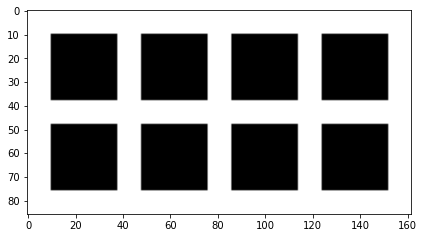

In [9]:
show_batch(a.imgs)

### Instantiate the model, optimizer and scheduler

In [10]:
#vae = CompositionalVae(config)
optimizer = instantiate_optimizer(model=vae, config_optimizer=config["optimizer"])

if config["simulation"]["type"] == "scratch":
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999

elif config["simulation"]["type"] == "resume":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=optimizer,
                   overwrite_member_var=True)

    epoch_restart = ckpt.get('epoch', -1)
    history_dict = ckpt.get('history_dict', {})
    try:
        min_test_loss = min(history_dict.get("test_loss", 999999))
    except:
        min_test_loss = 999999

elif config["simulation"]["type"] == "pretrained":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=None,
                   overwrite_member_var=False)
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999
    
else:
    raise Exception("simulation type is NOT recognized")
    
# instantiate the scheduler if necessary    
if config["scheduler"]["is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, config_scheduler=config["scheduler"])
else:
    scheduler = None

### Training loop

In [12]:
TEST_FREQUENCY = config["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = config["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = config["simulation"]["MAX_EPOCHS"]

for epoch in range(0,NUM_EPOCHS+1):
    
    
    vae.train()
    train_metrics = process_one_epoch(model=vae,
                                      dataloader=train_loader,
                                      optimizer=optimizer,
                                      scheduler=scheduler,
                                      iom_threshold=config["architecture"]["nms_threshold_train"],
                                      verbose=(epoch == 0))
    
    with torch.no_grad():
        print("Train " + train_metrics.pretty_print(epoch))
        history_dict = append_to_dict(source=train_metrics,
                                      destination=history_dict,
                                      prefix_exclude="wrong_examples",
                                      prefix_to_add="train_")
        
        if (epoch % TEST_FREQUENCY) == 0:
            vae.eval()
            test_metrics = process_one_epoch(model=vae,
                                             dataloader=test_loader,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             iom_threshold=config["architecture"]["nms_threshold_test"],
                                             verbose=(epoch == 0))
            print("Test  "+test_metrics.pretty_print(epoch))
            history_dict = append_to_dict(source=test_metrics,
                                          destination=history_dict,
                                          prefix_exclude="wrong_examples",
                                          prefix_to_add="test_")
            
        #if (epoch % CHECKPOINT_FREQUENCY == 0) and (epoch >= 20):
        #    ckpt = vae.create_ckpt(optimizer=optimizer,
        #                           epoch=epoch,
        #                           history_dict=history_dict)
        #    ckpt2file(ckpt=ckpt, path="last_ckpt_"+str(epoch))

i =   0 train_loss=0.92865
i =   1 train_loss=1.18987
i =   2 train_loss=1.24989
i =   3 train_loss=1.12447
i =   4 train_loss=0.98644
i =   5 train_loss=1.06791
i =   6 train_loss=1.09260
i =   7 train_loss=0.91932
i =   8 train_loss=1.15315
i =   9 train_loss=1.03043
i =  10 train_loss=0.91452
i =  11 train_loss=1.11085
i =  12 train_loss=0.86952
i =  13 train_loss=0.95236
i =  14 train_loss=1.09401
i =  15 train_loss=1.02630
i =  16 train_loss=1.16243
i =  17 train_loss=0.93479
i =  18 train_loss=1.07272
i =  19 train_loss=1.19390
i =  20 train_loss=1.04736
i =  21 train_loss=1.05496
i =  22 train_loss=1.05336
i =  23 train_loss=0.94192
i =  24 train_loss=1.08241
i =  25 train_loss=1.18514
i =  26 train_loss=1.06210
i =  27 train_loss=1.00377
i =  28 train_loss=1.11205
i =  29 train_loss=0.94864
i =  30 train_loss=0.86681
i =  31 train_loss=1.08802
i =  32 train_loss=1.03140
i =  33 train_loss=0.98847
i =  34 train_loss=1.24265
i =  35 train_loss=1.02005
i =  36 train_loss=0.93427
i

i = 307 train_loss=0.98617
i = 308 train_loss=0.81158
i = 309 train_loss=0.94736
i = 310 train_loss=0.95421
i = 311 train_loss=0.98446
i = 312 train_loss=0.89871
i = 313 train_loss=0.91030
i = 314 train_loss=0.91048
i = 315 train_loss=0.96852
i = 316 train_loss=0.97852
i = 317 train_loss=1.02654
i = 318 train_loss=1.01961
i = 319 train_loss=0.90350
i = 320 train_loss=1.00795
i = 321 train_loss=1.06515
i = 322 train_loss=0.77101
i = 323 train_loss=1.03736
i = 324 train_loss=0.88608
i = 325 train_loss=0.85244
i = 326 train_loss=0.83088
i = 327 train_loss=0.80851
i = 328 train_loss=0.88423
i = 329 train_loss=0.88566
i = 330 train_loss=0.77162
i = 331 train_loss=1.12846
i = 332 train_loss=1.04342
i = 333 train_loss=1.23629
i = 334 train_loss=0.84805
i = 335 train_loss=1.01462
i = 336 train_loss=0.87197
i = 337 train_loss=0.93148
i = 338 train_loss=1.01823
i = 339 train_loss=1.09053
i = 340 train_loss=0.84831
i = 341 train_loss=1.11708
i = 342 train_loss=0.89715
i = 343 train_loss=1.01020
i

KeyboardInterrupt: 

In [ ]:
output = vae(img)

In [ ]:
show_batch(img)

In [ ]:
show_batch(output.imgs)

In [ ]:
output.inference.index.shape

In [ ]:
plt.imshow(output.imgs[0,0].detach().cpu())

In [ ]:
output.inference.index[0,0]

In [ ]:
plt.imshow(output.inference.index[0,0].cpu())
plt.grid()

In [ ]:
show_batch(output.inference.index, n_padding=2, pad_value=255)

### Visualize the results (for example MSE)

In [ ]:
plt.imshow()